## **Imports**

In [12]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

## **Paths & Global Variables**

In [13]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

## **Reading Data**

In [14]:
os.chdir(PROCESSED_DATA_DIR)

features_selected = pd.read_json("dtree_features.json").index.to_list()

X_train = pd.read_parquet("X_train.parquet", columns=features_selected)
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_val.parquet", columns=features_selected)
y_test = pd.read_parquet("y_val.parquet")

# **Decision Trees**

## **Model Fitting**

In [15]:
dtree = DecisionTreeClassifier(max_depth=8, ccp_alpha=0.01, criterion="gini")

dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=8)

### **Visualizing Decision Trees**

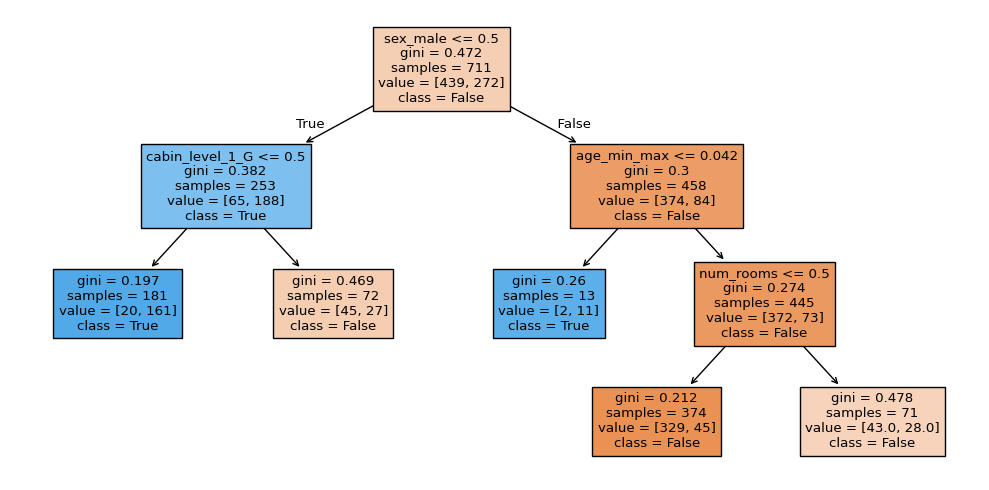

In [16]:
plt.figure(figsize=(10, 5))
tree.plot_tree(
    dtree,
    feature_names=X_train.columns,
    max_depth=10,
    class_names=["False", "True"],
    label="all",
    filled=True,
)
plt.tight_layout()
plt.show()

In [17]:
print(tree.export_text(dtree, feature_names=X_train.columns))

|--- sex_male <= 0.50
|   |--- cabin_level_1_G <= 0.50
|   |   |--- class: True
|   |--- cabin_level_1_G >  0.50
|   |   |--- class: False
|--- sex_male >  0.50
|   |--- age_min_max <= 0.04
|   |   |--- class: True
|   |--- age_min_max >  0.04
|   |   |--- num_rooms <= 0.50
|   |   |   |--- class: False
|   |   |--- num_rooms >  0.50
|   |   |   |--- class: False



## **Model Testing**

In [18]:
y_predicted = dtree.predict(X_test)
y_predicted_probs = dtree.predict_proba(X_test)[:, 1]

In [19]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(
    y_predicted_probs, columns=["probability"], index=X_test.index
)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.120321
127,False,0.120321
429,False,0.120321
423,False,0.120321
566,False,0.120321


## **Evaluation Metrics**

In [20]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,101,9
actual yes,28,40


In [21]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.792135
Precision,0.816327
Recall,0.588235
F1 Score,0.683761
ROC AUC,0.829612
Gini,0.659225


## **Model & Prediction Export**

In [22]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(dtree, "dtree-model.joblib")
y_predicted_df.to_parquet("dtree-y_predicted.parquet")